#### 1. Data import and device

In [1]:
from IPython.display import display
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
from pathlib import Path
from collections import Counter
import pandas as pd
import plotly.express as px
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
# --- config ---
ROOT = Path().resolve()
DATA_DIR = os.path.join(ROOT, "data", "archive", "Dataset")
IMG_SIZE = 224
BATCH_SIZE = 64
VAL_SPLIT = 0.2
SEED = 42
NUM_WORKERS = 2
PIN = torch.cuda.is_available()

# --- transforms ---
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(0.1, 0.1, 0.05),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


def get_loaders(
        data_dir: str = DATA_DIR,
        batch_size: int = BATCH_SIZE,
        val_split: float = VAL_SPLIT,
        seed: int = SEED,
        num_workers: int = NUM_WORKERS,
        pin_memory: bool = PIN,
):
    full = torchvision.datasets.ImageFolder(root=data_dir, transform=train_tf)
    n = len(full)
    n_val = int(n * val_split)
    n_train = n - n_val

    g = torch.Generator().manual_seed(seed)
    train_set, val_set = random_split(full, [n_train, n_val], generator=g)

    # clean tf for val
    val_set.dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=val_tf)

    class_to_idx = full.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size * 2, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    return train_loader, val_loader, idx_to_class


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, idx_to_class = get_loaders()

xb, yb = next(iter(train_loader))


#### 2.Data visualization

show image amount, show class amount,and batch size

In [3]:
print("Using device:", device)
print(f"Total images: {len(train_loader.dataset) + len(val_loader.dataset)}  |  "
      f"Train: {len(train_loader.dataset)}  Val: {len(val_loader.dataset)}")
print("Num classes:", len(idx_to_class))
print("Classes:", list(idx_to_class.values()))
print("Batch:", xb.shape, yb.shape)


Using device: cpu
Total images: 35725  |  Train: 28580  Val: 7145
Num classes: 23
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Batch: torch.Size([64, 3, 224, 224]) torch.Size([64])


Display the first 10 images from the dataset.

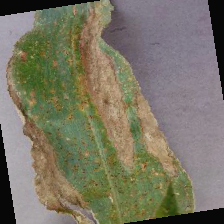

Corn_(maize)___Northern_Leaf_Blight

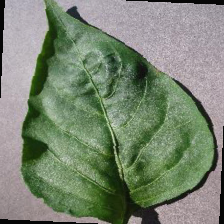

Pepper__bell___healthy

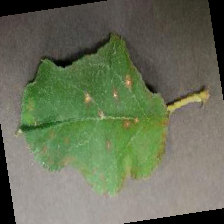

Apple___Cedar_apple_rust

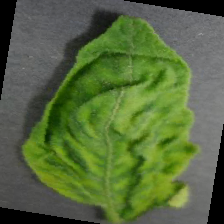

Tomato__Tomato_YellowLeaf__Curl_Virus

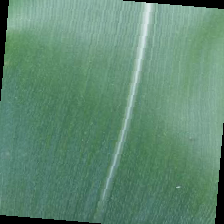

Corn_(maize)___healthy

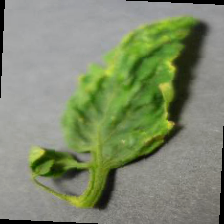

Tomato__Tomato_YellowLeaf__Curl_Virus

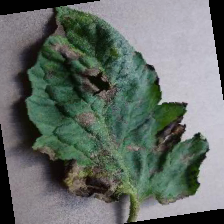

Tomato_Early_blight

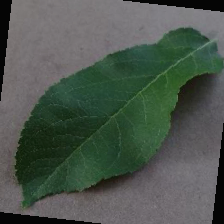

Apple___healthy

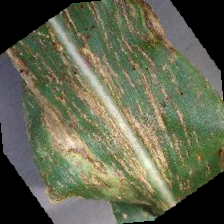

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot

In [4]:
dataset = train_loader.dataset
for i in range(9):
    img, label = dataset[i]
    # --- 反归一化 ---
    img = img.detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    if img.shape[0] == 3:
        img = img * std + mean

    # --- CHW -> HWC + 转成 0~255 uint8 ---
    img = img.permute(1, 2, 0).clamp(0, 1)  # HWC, [0,1]
    img = (img * 255).byte().numpy()  # uint8 array

    # --- 转 PIL 图像并显示 ---
    img = Image.fromarray(img)
    display(img)

    real_class_name = idx_to_class[label]
    print(real_class_name, end="")

Count images per class to check class balance.

In [5]:
labels = []
for img, label in dataset:
    labels.append(idx_to_class[label])

print(Counter(labels))

Counter({'Tomato__Tomato_YellowLeaf__Curl_Virus': 2555, 'Tomato_Bacterial_spot': 1738, 'Apple___healthy': 1630, 'Apple___Apple_scab': 1627, 'Apple___Black_rot': 1584, 'Tomato_Late_blight': 1535, 'Corn_(maize)___Northern_Leaf_Blight': 1519, 'Corn_(maize)___Common_rust_': 1518, 'Corn_(maize)___healthy': 1500, 'Tomato_Septoria_leaf_spot': 1419, 'Apple___Cedar_apple_rust': 1408, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1321, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1305, 'Tomato_healthy': 1254, 'Pepper__bell___healthy': 1188, 'Tomato__Target_Spot': 1138, 'Potato___Late_blight': 809, 'Potato___Early_blight': 805, 'Tomato_Early_blight': 793, 'Pepper__bell___Bacterial_spot': 783, 'Tomato_Leaf_Mold': 750, 'Tomato__Tomato_mosaic_virus': 279, 'Potato___healthy': 122})


In [6]:
count = Counter(labels)

# 构造 DataFrame（关键在这里）
df = pd.DataFrame(sorted(count.items(), key=lambda x: x[0]), columns=["class", "count"])

# 直接可视化（Jupyter里自动显示，不会卡）
fig = px.bar(df, x="class", y="count", title="Class Distribution", text="count")
fig.update_traces(textposition="outside", cliponaxis=False)
fig.update_layout(xaxis_tickangle=-45)

display(fig)

#### 3. Data cleaning

In [7]:
### 3. Data cleaning
import shutil
from PIL import Image, UnidentifiedImageError
import numpy as np
from tqdm import tqdm

CLEAN_DIR = os.path.join(ROOT, "data", "clean")  # 输出干净数据的镜像目录
MIN_SIDE = 64  # 过小图片阈值（任一边 < MIN_SIDE 则剔除）
ALLOW_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}  # 可自行增减
DO_DEDUP = True  # 是否进行感知哈希去重
DEDUPE_SCOPE = "global"  # "class" 仅类内去重, "global" 全局去重


def _safe_ext(p: Path) -> str:
    return p.suffix.lower()


def _is_image_file(p: Path) -> bool:
    return _safe_ext(p) in ALLOW_EXTS


def _pil_open_rgb(path: str):
    """打开并转 RGB，返回 (img, w, h)。失败抛异常。"""
    with Image.open(path) as im:
        im.load()
        im = im.convert("RGB")
        w, h = im.size
    return im, w, h


def _ahash(img: Image.Image, hash_size: int = 8) -> int:
    """简单 aHash：缩放灰度 -> 与均值比较 -> bit 布尔阵列 -> 整数"""
    g = img.convert("L").resize((hash_size, hash_size), Image.BILINEAR)
    arr = np.asarray(g, dtype=np.float32)
    mean = arr.mean()
    bits = (arr >= mean).astype(np.uint8).ravel()
    # 将 64bit 布尔转整数
    h = 0
    for b in bits:
        h = (h << 1) | int(b)
    return h


def _iter_class_images(root_dir: str):
    """遍历 ImageFolder 结构：root/class_x/xxx.jpg -> 产出 (class_name, path)"""
    root = Path(root_dir)
    for cls_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        cls = cls_dir.name
        for p in cls_dir.rglob("*"):
            if p.is_file() and _is_image_file(p):
                yield cls, p


def scan_and_clean(
        src_dir: str = DATA_DIR,
        dst_dir: str = CLEAN_DIR,
        min_side: int = MIN_SIDE,
        do_dedup: bool = DO_DEDUP,
        dedupe_scope: str = DEDUPE_SCOPE,
):
    """
    扫描 src_dir -> 清洗 -> 拷贝到 dst_dir。返回清洗统计与重复信息。
    """
    # 清空/重建输出目录
    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)
    os.makedirs(dst_dir, exist_ok=True)

    stats = {
        "total_found": 0,
        "copied": 0,
        "skipped_unreadable": 0,
        "skipped_too_small": 0,
        "skipped_other": 0,
        "by_class": {},  # {class: count}
    }

    # 去重缓存
    seen_hashes_global = {}
    seen_hashes_per_class = {}

    problems = {
        "unreadable": [],  # (class, path)
        "too_small": [],  # (class, path, size)
        "dup_same_class": [],  # (class, path, dup_of_path)
        "dup_cross_class": [],  # (class, path, dup_class, dup_of_path)
        "bad_ext": [],  # (class, path)
    }

    for cls, path in tqdm(list(_iter_class_images(src_dir)), desc="Scanning"):
        stats["total_found"] += 1
        # 打开图片 & 基本过滤
        try:
            img, w, h = _pil_open_rgb(str(path))
        except (UnidentifiedImageError, OSError) as e:
            stats["skipped_unreadable"] += 1
            problems["unreadable"].append((cls, str(path)))
            continue

        if min(w, h) < min_side:
            stats["skipped_too_small"] += 1
            problems["too_small"].append((cls, str(path), (w, h)))
            continue

        # 扩展名检查（允许但会统一保存为 .jpg）
        if _safe_ext(path) not in ALLOW_EXTS:
            problems["bad_ext"].append((cls, str(path)))

        # 去重（可选）
        is_dup = False
        dup_of = None
        if do_dedup:
            hval = _ahash(img)  # int
            if dedupe_scope == "class":
                seen_hashes_per_class.setdefault(cls, {})
                if hval in seen_hashes_per_class[cls]:
                    is_dup = True
                    dup_of = seen_hashes_per_class[cls][hval]
                    problems["dup_same_class"].append((cls, str(path), dup_of))
                else:
                    seen_hashes_per_class[cls][hval] = str(path)
            else:  # global
                if hval in seen_hashes_global:
                    prev_cls, prev_path = seen_hashes_global[hval]
                    is_dup = True
                    dup_of = prev_path
                    if prev_cls == cls:
                        problems["dup_same_class"].append((cls, str(path), dup_of))
                    else:
                        problems["dup_cross_class"].append((cls, str(path), prev_cls, dup_of))
                else:
                    seen_hashes_global[hval] = (cls, str(path))

        if is_dup:
            # 直接跳过重复项
            stats["skipped_other"] += 1
            continue

        # 保存为统一 jpg 到 dst_dir/class/filename.jpg（保留相对结构）
        out_cls_dir = Path(dst_dir) / cls
        out_cls_dir.mkdir(parents=True, exist_ok=True)

        # 文件名去除原扩展，统一 .jpg
        stem = path.stem
        out_path = out_cls_dir / f"{stem}.jpg"

        # 若重名则添加计数后缀
        suf_idx = 1
        while out_path.exists():
            out_path = out_cls_dir / f"{stem}__{suf_idx}.jpg"
            suf_idx += 1

        img.save(out_path, format="JPEG", quality=95)
        stats["copied"] += 1
        stats["by_class"][cls] = stats["by_class"].get(cls, 0) + 1

    return stats, problems


stats, problems = scan_and_clean()
print("=== Clean Summary ===")
print(stats)
print("Unreadable:", len(problems["unreadable"]),
      "| Too small:", len(problems["too_small"]),
      "| Dup(same class):", len(problems["dup_same_class"]),
      "| Dup(cross class):", len(problems["dup_cross_class"]))


Scanning: 100%|██████████| 35725/35725 [09:02<00:00, 65.91it/s] 

=== Clean Summary ===
{'total_found': 35725, 'copied': 35386, 'skipped_unreadable': 0, 'skipped_too_small': 0, 'skipped_other': 339, 'by_class': {'Apple___Apple_scab': 2016, 'Apple___Black_rot': 1981, 'Apple___Cedar_apple_rust': 1727, 'Apple___healthy': 1995, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1642, 'Corn_(maize)___Common_rust_': 1903, 'Corn_(maize)___healthy': 1850, 'Corn_(maize)___Northern_Leaf_Blight': 1905, 'Pepper__bell___Bacterial_spot': 997, 'Pepper__bell___healthy': 1465, 'Potato___Early_blight': 1000, 'Potato___healthy': 150, 'Potato___Late_blight': 992, 'Tomato__Target_Spot': 1393, 'Tomato__Tomato_mosaic_virus': 373, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3184, 'Tomato_Bacterial_spot': 2085, 'Tomato_Early_blight': 988, 'Tomato_healthy': 1543, 'Tomato_Late_blight': 1885, 'Tomato_Leaf_Mold': 943, 'Tomato_Septoria_leaf_spot': 1761, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1608}}
Unreadable: 0 | Too small: 0 | Dup(same class): 180 | Dup(cross class): 15

In [8]:
### 3.1 Inspect issues & class distribution after cleaning
from collections import Counter
import pandas as pd
import plotly.express as px


def _preview_list(name, items, k=5):
    print(f"\n-- {name} (showing up to {k}) --")
    for row in items[:k]:
        print(row)


_preview_list("unreadable", problems["unreadable"])
_preview_list("too_small", problems["too_small"])
_preview_list("dup_same_class", problems["dup_same_class"])
_preview_list("dup_cross_class", problems["dup_cross_class"])

# 清洗后类分布
clean_counts = Counter()
for cls, p in _iter_class_images(CLEAN_DIR):
    clean_counts[cls] += 1

df_clean = pd.DataFrame(sorted(clean_counts.items(), key=lambda x: x[0]), columns=["class", "count"])
fig = px.bar(df_clean, x="class", y="count", title="Class Distribution (CLEANED)", text="count")
fig.update_traces(textposition="outside", cliponaxis=False)
fig.update_layout(xaxis_tickangle=-45)
display(fig)

print("Total after cleaning:", sum(clean_counts.values()))



-- unreadable (showing up to 5) --

-- too_small (showing up to 5) --

-- dup_same_class (showing up to 5) --
('Apple___Black_rot', 'D:\\UWO\\2025fall\\DS3000A\\new_group_project\\data\\archive\\Dataset\\Apple___Black_rot\\6f38c615-281d-4bf5-8d92-7c02d3ef9e1b___JR_FrgE.S 8753_270deg.JPG', 'D:\\UWO\\2025fall\\DS3000A\\new_group_project\\data\\archive\\Dataset\\Apple___Black_rot\\4db50338-6897-4d69-8147-717cae13879c___JR_FrgE.S 8645_270deg.JPG')
('Apple___Black_rot', 'D:\\UWO\\2025fall\\DS3000A\\new_group_project\\data\\archive\\Dataset\\Apple___Black_rot\\769283e3-f7ec-4e62-b907-4b22d1bda1ea___JR_FrgE.S 8618.JPG', 'D:\\UWO\\2025fall\\DS3000A\\new_group_project\\data\\archive\\Dataset\\Apple___Black_rot\\68566f26-8158-4fd5-9c5f-0a29eec5225a___JR_FrgE.S 8746.JPG')
('Apple___Black_rot', 'D:\\UWO\\2025fall\\DS3000A\\new_group_project\\data\\archive\\Dataset\\Apple___Black_rot\\769283e3-f7ec-4e62-b907-4b22d1bda1ea___JR_FrgE.S 8618_270deg.JPG', 'D:\\UWO\\2025fall\\DS3000A\\new_group_project\

Total after cleaning: 35386


In [9]:
### 3.2 Enhancement — imbalance handling, RandAugment & MixUp
from torch.utils.data import WeightedRandomSampler


# 计算类别采样权重（用于 WeightedRandomSampler）
def compute_sampler_weights(root_dir: str = CLEAN_DIR):
    class_to_idx = {}
    # 使用与 ImageFolder 相同的类别顺序
    for i, cls in enumerate(sorted([d.name for d in Path(root_dir).iterdir() if d.is_dir()])):
        class_to_idx[cls] = i

    per_class_counts = np.zeros(len(class_to_idx), dtype=np.int64)
    samples = []  # (path, class_idx)

    for cls, p in _iter_class_images(root_dir):
        ci = class_to_idx[cls]
        per_class_counts[ci] += 1
        samples.append((str(p), ci))

    # 避免除零
    per_class_counts = np.maximum(per_class_counts, 1)
    class_weights = 1.0 / per_class_counts
    weights = [class_weights[ci] for _, ci in samples]

    # 不平衡度
    imb_ratio = float(per_class_counts.max() / per_class_counts.min())
    return weights, class_to_idx, per_class_counts, imb_ratio


weights, class_to_idx_clean, per_class_counts, imb_ratio = compute_sampler_weights(CLEAN_DIR)
print("Class order:", class_to_idx_clean)
print("Counts:", per_class_counts, "| imbalance ratio (max/min):", round(imb_ratio, 3))

USE_SAMPLER = imb_ratio >= 1.5  # 阈值
print("USE_SAMPLER =", USE_SAMPLER)

# 自动拼接 RandAugment 到 train_tf
try:
    if hasattr(T, "RandAugment"):
        train_tf = T.Compose([
            T.Resize((IMG_SIZE, IMG_SIZE)),
            T.RandAugment(num_ops=2, magnitude=7),
            T.RandomHorizontalFlip(0.5),
            T.RandomRotation(10),
            T.ColorJitter(0.1, 0.1, 0.05),
            T.ToTensor(),
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
        print("RandAugment enabled.")
    else:
        print("RandAugment not available in this torchvision version; skipped.")
except Exception as e:
    print("Failed to enable RandAugment:", e)


# MixUp collate_fn（训练 loader 使用）
def mixup_collate_fn(batch, alpha: float = 0.2, num_classes: int = None):
    """
    batch: list of (img_tensor[C,H,W], label_idx)
    返回： (mixed_x, mixed_y_onehot) with lambda
    """
    xs, ys = zip(*batch)
    x = torch.stack(xs, dim=0)
    y = torch.tensor(ys, dtype=torch.long)

    if num_classes is None:
        num_classes = len(class_to_idx_clean)

    lam = np.random.beta(alpha, alpha) if alpha > 0.0 else 1.0
    index = torch.randperm(x.size(0))

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_onehot = torch.zeros((x.size(0), num_classes), dtype=torch.float32)
    y_onehot.scatter_(1, y.view(-1, 1), 1.0)
    y_shuffled = y[index]
    y_shuf_onehot = torch.zeros_like(y_onehot)
    y_shuf_onehot.scatter_(1, y_shuffled.view(-1, 1), 1.0)

    mixed_y = lam * y_onehot + (1 - lam) * y_shuf_onehot
    return mixed_x, mixed_y


Class order: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 4, 'Corn_(maize)___Common_rust_': 5, 'Corn_(maize)___Northern_Leaf_Blight': 6, 'Corn_(maize)___healthy': 7, 'Pepper__bell___Bacterial_spot': 8, 'Pepper__bell___healthy': 9, 'Potato___Early_blight': 10, 'Potato___Late_blight': 11, 'Potato___healthy': 12, 'Tomato_Bacterial_spot': 13, 'Tomato_Early_blight': 14, 'Tomato_Late_blight': 15, 'Tomato_Leaf_Mold': 16, 'Tomato_Septoria_leaf_spot': 17, 'Tomato_Spider_mites_Two_spotted_spider_mite': 18, 'Tomato__Target_Spot': 19, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 20, 'Tomato__Tomato_mosaic_virus': 21, 'Tomato_healthy': 22}
Counts: [2016 1981 1727 1995 1642 1903 1905 1850  997 1465 1000  992  150 2085
  988 1885  943 1761 1608 1393 3184  373 1543] | imbalance ratio (max/min): 21.227
USE_SAMPLER = True
RandAugment enabled.


In [10]:
### 3.3 Rebuild loaders from CLEAN_DIR
def get_loaders_clean(
        data_dir: str = CLEAN_DIR,
        batch_size: int = BATCH_SIZE,
        val_split: float = VAL_SPLIT,
        seed: int = SEED,
        num_workers: int = NUM_WORKERS,
        pin_memory: bool = PIN,
        use_sampler: bool = USE_SAMPLER,
        use_mixup: bool = False
):
    full = torchvision.datasets.ImageFolder(root=data_dir, transform=train_tf)
    n = len(full)
    n_val = int(n * val_split)
    n_train = n - n_val

    g = torch.Generator().manual_seed(seed)
    train_set, val_set = random_split(full, [n_train, n_val], generator=g)
    # val 使用干净的 tf
    val_set.dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=val_tf)

    class_to_idx = full.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # 构建采样器（仅训练集）
    sampler = None
    if use_sampler:
        # 需要把 weights 对应到 train_set 的索引
        # 重新基于 train_set 的样本路径计算权重
        train_paths = []
        train_labels = []
        for i in range(len(train_set)):
            p, y = full.samples[train_set.indices[i]]  # (path, class_idx)
            train_paths.append(p)
            train_labels.append(y)

        # 统计训练集内的 per-class counts
        tr_counts = np.zeros(len(class_to_idx), dtype=np.int64)
        for y in train_labels:
            tr_counts[y] += 1
        tr_counts = np.maximum(tr_counts, 1)
        tr_class_w = 1.0 / tr_counts
        tr_weights = torch.DoubleTensor([tr_class_w[y] for y in train_labels])
        sampler = WeightedRandomSampler(tr_weights, num_samples=len(tr_weights), replacement=True)

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=(sampler is None),
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
        collate_fn=(lambda b: mixup_collate_fn(b, alpha=0.2, num_classes=len(class_to_idx))) if use_mixup else None
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size * 2, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    return train_loader, val_loader, idx_to_class


# 使用 CLEAN 集合重建 DataLoader
train_loader, val_loader, idx_to_class = get_loaders_clean(
    use_sampler=USE_SAMPLER,
    use_mixup=False,  # 如需 MixUp，将其改为 True；注意你的损失函数需支持 soft labels（如 BCE 或自定义 KL/CE）
)

xb, yb = next(iter(train_loader))
print("CLEAN train batch:", xb.shape, "| y type:", type(yb))


CLEAN train batch: torch.Size([64, 3, 224, 224]) | y type: <class 'torch.Tensor'>


#### 4. Model and comparison model

In [11]:
def build_resnet50_classifier(num_classes=23, input_shape=(224, 224, 3), base_trainable=False):
    input = layers.Input(shape=input_shape)
    x = preprocess_input(input)                    # preprocess
    base = ResNet50(include_top=False, weights="imagenet", input_tensor=x)
    base.trainable = base_trainable
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(input, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top3")])
    return model


EfficientNetB0

In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet_classifier(num_classes=23, input_shape=(224,224,3), base_trainable=False):
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)

    base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    base.trainable = base_trainable

    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3')]
    )
    return model


#### 5. Model training

#### 6. Model performance comparison & CV